In [ ]:
import duckdb
import os
import pandas as pd
from dotenv import load_dotenv
from kaggle.api.kaggle_api_extended import KaggleApi
from datetime import datetime, timezone
import glob
import re
import json

# --- CONFIGURACIÓN ---
DB_PATH = "app/data/DB/entrenamiento.duckdb"
RAW_DIR = "app/data/artifacts/RAW"
PARQUET_DIR = "app/data/artifacts/parquet"
PARQUET_PATH = os.path.join(PARQUET_DIR, "entrenamiento.parquet")

LEGACY_CSV_PATH = os.path.join(RAW_DIR, "entrenamiento.csv")
KAGGLE_FILE_BASE = "entrenamiento"
VERSIONED_CSV_PATTERN = os.path.join(RAW_DIR, f"{KAGGLE_FILE_BASE}-*.csv")
DATE_FORMAT = "%Y-%m-%d"
KAGGLE_DATASET = "alejandroczernikier/properati-argentina-dataset"
KAGGLE_FILE_NAME = "entrenamiento.csv"

load_dotenv()


# === UTILIDADES ===
def ensure_directories():
    os.makedirs(RAW_DIR, exist_ok=True)
    os.makedirs(PARQUET_DIR, exist_ok=True)
    os.makedirs(os.path.dirname(DB_PATH), exist_ok=True)


def find_latest_local_versioned_file(pattern: str, date_format: str):
    #Busca el archivo versionado más reciente según el nombre
    latest_date = None
    latest_file = None
    date_pattern = re.compile(rf'{KAGGLE_FILE_BASE}-(\d{{4}}-\d{{2}}-\d{{2}})\.csv')

    for filepath in glob.glob(pattern):
        match = date_pattern.search(os.path.basename(filepath))
        if match:
            date_str = match.group(1)
            try:
                file_date = datetime.strptime(date_str, date_format).replace(tzinfo=timezone.utc)
                if latest_date is None or file_date > latest_date:
                    latest_date = file_date
                    latest_file = filepath
            except ValueError:
                pass
    return latest_file, latest_date


def get_kaggle_dataset_update_time(dataset_slug: str):
    # fecha de última actualización desde la API de Kaggle
    print("Contactando API de Kaggle para verificar la última actualización del dataset...")
    import requests
    from requests.auth import HTTPBasicAuth

    try:
        api = KaggleApi()
        api.authenticate()

        username = os.getenv("KAGGLE_USERNAME")
        key = os.getenv("KAGGLE_KEY")

        # Fallback: leer desde kaggle.json si no está en el entorno
        if not username or not key:
            kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")
            if os.path.exists(kaggle_json_path):
                with open(kaggle_json_path, "r") as f:
                    creds = json.load(f)
                    username = creds.get("username")
                    key = creds.get("key")

        if not username or not key:
            raise ValueError("Faltan credenciales KAGGLE_USERNAME o KAGGLE_KEY en el entorno o kaggle.json.")

        url = f"https://www.kaggle.com/api/v1/datasets/view/{dataset_slug}"
        response = requests.get(url, auth=HTTPBasicAuth(username, key))
        response.raise_for_status()
        metadata = response.json()

        kaggle_date_str = metadata.get("lastUpdated")
        if kaggle_date_str:
            for fmt in ("%Y-%m-%dT%H:%M:%S.%fZ", "%Y-%m-%dT%H:%M:%SZ"):
                try:
                    kaggle_date = datetime.strptime(kaggle_date_str, fmt).replace(tzinfo=timezone.utc)
                    print(f"Fecha de última actualización en Kaggle: {kaggle_date}")
                    return kaggle_date
                except ValueError:
                    continue
        print("Advertencia: no se pudo interpretar la fecha 'lastUpdated'.")
        return None

    except Exception as e:
        print(f"ERROR: Fallo al contactar la API de Kaggle: {e}")
        return None


def download_from_kaggle_and_rename(dataset_slug: str, file_name: str, kaggle_time: datetime, date_format: str):
   #Descarga el dataset desde Kaggle y lo renombra según la fecha de metadata Kaggle
    date_str = kaggle_time.strftime(date_format) if kaggle_time else datetime.now().strftime(date_format)
    new_filename = f"{KAGGLE_FILE_BASE}-{date_str}.csv"
    new_filepath = os.path.join(RAW_DIR, new_filename)
    original_download_path = os.path.join(RAW_DIR, file_name)

    print(f"Descargando {file_name} desde Kaggle...")
    try:
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files(dataset_slug, path=RAW_DIR, unzip=True, force=True)

        if not os.path.exists(original_download_path):
            print(f"ERROR: No se encontró {original_download_path} después de descargar")
            return None

        if os.path.exists(new_filepath):
            os.remove(new_filepath)
        os.rename(original_download_path, new_filepath)
        print(f"Descarga completa y renombrada a {new_filepath}")
        return new_filepath
    except Exception as e:
        print(f"ERROR: Fallo la descarga de Kaggle: {e}")
        return None

   # Carga el CSV en DuckDB y genera un Parquet
def run_duckdb_pipeline(csv_path_to_load: str):
 
    if not os.path.exists(csv_path_to_load):
        print(f"ERROR: No existe {csv_path_to_load}.")
        return
    print(f"\nConectando a DuckDB en {DB_PATH}...")
    try:
        con = duckdb.connect(DB_PATH)
        con.execute(f"""
            CREATE OR REPLACE TABLE datos_raw AS 
            SELECT * FROM read_csv_auto('{csv_path_to_load}')
        """)
        print("Tabla 'datos_raw' actualizada.")
        con.execute(f"""
            COPY (
                SELECT * FROM datos_raw
            ) TO '{PARQUET_PATH}' (FORMAT PARQUET, OVERWRITE_OR_IGNORE TRUE)
        """)
        print(f"parquet generado en {PARQUET_PATH}.")
    finally:
        con.close()


# ingesta
def process_entrenamiento():
    ensure_directories()

    file_to_process = None
    needs_db_update = False

    if os.path.exists(LEGACY_CSV_PATH):
        print(f"Se encontró el archivo legacy '{LEGACY_CSV_PATH}'. No es necesario conectar a Kaggle.")
        file_to_process = LEGACY_CSV_PATH
        needs_db_update = True
    else:
        print(" Verificando archivos CSV")
        local_filepath, local_date = find_latest_local_versioned_file(VERSIONED_CSV_PATTERN, DATE_FORMAT)
        kaggle_time = get_kaggle_dataset_update_time(KAGGLE_DATASET)

        if not local_filepath:
            print("No hay archivo local. Descargando desde Kaggle...")
            new_path = download_from_kaggle_and_rename(KAGGLE_DATASET, KAGGLE_FILE_NAME, kaggle_time, DATE_FORMAT)
            if new_path:
                file_to_process = new_path
                needs_db_update = True
            else:
                print("❌ ERROR: Fallo al descargar desde Kaggle. Exit")
        elif kaggle_time and kaggle_time.date() > local_date.date():
            print(f"Kaggle ({kaggle_time.date()}) es más reciente que local ({local_date.date()}). Descargando nueva versión...")
            new_path = download_from_kaggle_and_rename(KAGGLE_DATASET, KAGGLE_FILE_NAME, kaggle_time, DATE_FORMAT)
            if new_path:
                file_to_process = new_path
                needs_db_update = True
                try:
                    os.remove(local_filepath)
                    print(f"Archivo anterior eliminado: {local_filepath}")
                except OSError as e:
                    print(f"Advertencia: No se pudo eliminar {local_filepath}: {e}")
        else:
            print(f"Archivo local ({local_filepath}) está actualizado (Fecha {local_date.date()}).")
            file_to_process = local_filepath

    if file_to_process and needs_db_update:
        print("\nActualizando DuckDB y Parquet...")
        run_duckdb_pipeline(file_to_process)
        print("\n Proceso completo")
    elif file_to_process:
        print(f"\nEl archivo {file_to_process} está actualizado. No se requiere actualización.")
    else:
        print("\n No hay archivo CSV disponible.")


In [26]:
process_entrenamiento()


 Verificando existencia de archivos CSV versionados...
Contactando API de Kaggle para verificar la última actualización del dataset...
Fecha de última actualización en Kaggle: 2025-04-16 18:36:22.320000+00:00
No hay archivo local. Descargando desde Kaggle...
Descargando entrenamiento.csv desde Kaggle...
Dataset URL: https://www.kaggle.com/datasets/alejandroczernikier/properati-argentina-dataset
Descarga completada y renombrada a app/data/artifacts/RAW\entrenamiento-2025-04-16.csv

Actualizando DuckDB y Parquet...

Conectando a DuckDB en app/data/DB/entrenamiento.duckdb...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Tabla 'datos_raw' actualizada.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Archivo Parquet generado en app/data/artifacts/parquet\entrenamiento.parquet.

✅ Proceso completado.


In [ ]:

DB_PATH = "app/data/DB/entrenamiento.duckdb"

con = duckdb.connect(DB_PATH)
tables = con.execute("SHOW TABLES").fetchall()
print("Tablas en DuckDB:")
for t in tables:
    print("-", t[0])

Tablas en la base DuckDB:
- datos_clean
- datos_raw


In [4]:
# cant. de filas
n_filas = duckdb.query(
    "SELECT COUNT(*) FROM 'app/data/artifacts/parquet/entrenamiento.parquet'"
).fetchone()[0]
print("Filas:", n_filas)

Filas: 992192


In [5]:
# profiling del dataset en parquet
parquet_file = "app/data/artifacts/parquet/entrenamiento.parquet"

con = duckdb.connect()

# Obtener metadatos de columnas
cols = con.execute(
    f"""
DESCRIBE SELECT * FROM parquet_scan('{parquet_file}')
"""
).fetchdf()

profiling_results = []

for _, row in cols.iterrows():
    col = row["column_name"]
    dtype = row["column_type"].lower()

    is_numeric = any(t in dtype for t in ["int", "decimal", "double", "float", "real"])

    stats_query = f"""
    SELECT
        '{col}' AS column,
        '{dtype}' AS dtype,
        COUNT(*) AS total,
        COUNT(*) FILTER (WHERE "{col}" IS NULL) AS nulls,
        COUNT(DISTINCT "{col}") AS distinct_values,
        { "MIN(" + col + ")" if is_numeric else "NULL" } AS min,
        { "MAX(" + col + ")" if is_numeric else "NULL" } AS max,
        { "AVG(" + col + ")" if is_numeric else "NULL" } AS mean,
        { "MEDIAN(" + col + ")" if is_numeric else "NULL" } AS median,
        { "QUANTILE(" + col + ", 0.25)" if is_numeric else "NULL" } AS Q1,
        { "QUANTILE(" + col + ", 0.75)" if is_numeric else "NULL" } AS Q3
    FROM parquet_scan('{parquet_file}')
    """

    stats = con.execute(stats_query).fetchdf()
    profiling_results.append(stats)

profile_df = pd.concat(profiling_results)

print("profiling completado")
display(profile_df)

profiling completado


C:\Users\beln3\AppData\Local\Temp\ipykernel_15128\3467387441.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  profile_df = pd.concat(profiling_results)


,column,dtype,total,nulls,distinct_values,min,max,mean,median,Q1,Q3
0,id,bigint,992192,0,992192,1.000000,1.000000e+06,500338.438758,500641.500000,250259.000000,750507.000000
0,ad_type,varchar,992192,0,1,NaN,NaN,NaN,NaN,NaN,NaN
0,start_date,date,992192,0,346,NaN,NaN,NaN,NaN,NaN,NaN
0,end_date,date,992192,0,450,NaN,NaN,NaN,NaN,NaN,NaN
0,created_on,date,992192,0,346,NaN,NaN,NaN,NaN,NaN,NaN
0,lat,double,992192,153198,317046,-180.000000,-3.504503e+01,-59.266586,-58.444383,-58.756011,-58.058966
0,lon,double,992192,152263,315745,-54.842464,8.505113e+01,-34.793745,-34.610508,-34.921709,-34.459156
0,l1,varchar,992192,0,4,NaN,NaN,NaN,NaN,NaN,NaN
0,l2,varchar,992192,0,42,NaN,NaN,NaN,NaN,NaN,NaN
0,l3,varchar,992192,57455,1262,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:

df = duckdb.query(
    """
    SELECT *
    FROM 'app/data/artifacts/parquet/entrenamiento.parquet'
    WHERE l2 = 'Capital Federal'
"""
).df()
con.close()

In [7]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249738 entries, 0 to 249737
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               249738 non-null  int64         
 1   ad_type          249738 non-null  object        
 2   start_date       249738 non-null  datetime64[us]
 3   end_date         249738 non-null  datetime64[us]
 4   created_on       249738 non-null  datetime64[us]
 5   lat              217583 non-null  float64       
 6   lon              217705 non-null  float64       
 7   l1               249738 non-null  object        
 8   l2               249738 non-null  object        
 9   l3               225456 non-null  object        
 10  l4               10091 non-null   object        
 11  l5               0 non-null       object        
 12  l6               0 non-null       object        
 13  rooms            171449 non-null  float64       
 14  bedrooms         122

In [8]:
# sacar vacios y duplicados
df_clean = df.dropna().drop_duplicates()

In [9]:
# profile del df solo de capital
def profile(df: pd.DataFrame):
    profile = pd.DataFrame(
        {
            "dtype": df.dtypes,
            "n_nulls": df.isnull().sum(),
            "n_unique": df.nunique(),
            "min": df.min(numeric_only=True),
            "Q1": df.quantile(0.25, numeric_only=True),
            "median": df.median(numeric_only=True),
            "mean": df.mean(numeric_only=True),
            "Q3": df.quantile(0.75, numeric_only=True),
            "max": df.max(numeric_only=True),
        }
    )
    return profile


profile_df = profile(df)
display(profile_df)

,dtype,n_nulls,n_unique,min,Q1,median,mean,Q3,max
ad_type,object,0,1,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms,float64,37245,18,1.000000,1.000000,1.000000,1.545119,2.000000,2.000000e+01
bedrooms,float64,127386,65,-2.000000,1.000000,2.000000,1.951525,3.000000,3.030000e+02
created_on,datetime64[us],0,346,NaN,NaN,NaN,NaN,NaN,NaN
currency,object,8291,2,NaN,NaN,NaN,NaN,NaN,NaN
description,object,0,156677,NaN,NaN,NaN,NaN,NaN,NaN
end_date,datetime64[us],0,448,NaN,NaN,NaN,NaN,NaN,NaN
id,int64,0,249738,5.000000,216169.000000,463253.500000,469234.024125,693799.000000,1.000000e+06
l1,object,0,1,NaN,NaN,NaN,NaN,NaN,NaN
l2,object,0,1,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
import numpy as np
# manejo de outliers: no elimina filas, recorta los valores extremos al límite permitido
def clip_outliers(df, profile_df):
    df_clipped = df.copy()
    for col in df_clipped.select_dtypes(include=np.number).columns:
        Q1 = profile_df.loc[col, "Q1"]
        Q3 = profile_df.loc[col, "Q3"]
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped

df = clip_outliers(df, profile_df)


In [12]:
# contenido de columnas
for col in ["l1", "l2", "l3", "l4", "l5", "l6"]:
    print(f"\n Valores únicos en {col}:")
    print(df[col].dropna().unique())


 Valores únicos en l1:
['Argentina']

 Valores únicos en l2:
['Capital Federal']

 Valores únicos en l3:
['Colegiales' 'Almagro' 'Villa Urquiza' 'Boedo' 'San Telmo' 'Barrio Norte'
 'Villa Devoto' 'Palermo' 'Monserrat' 'Caballito' 'Balvanera'
 'Villa Ortuzar' 'Villa Crespo' 'Once' 'Saavedra' 'Recoleta'
 'Villa General Mitre' 'Villa del Parque' 'Belgrano' 'Mataderos'
 'Floresta' 'Coghlan' 'Flores' 'Velez Sarsfield' 'Parque Chacabuco'
 'Nuñez' 'Constitución' 'Las Cañitas' 'Villa Riachuelo' 'Puerto Madero'
 'Paternal' 'Congreso' 'Parque Centenario' 'Parque Patricios' 'Pompeya'
 'Villa Lugano' 'San Cristobal' 'Villa Real' 'San Nicolás' 'Boca'
 'Versalles' 'Villa Luro' 'Retiro' 'Chacarita' 'Barracas' 'Monte Castro'
 'Villa Pueyrredón' 'Parque Avellaneda' 'Liniers' 'Abasto' 'Tribunales'
 'Centro / Microcentro' 'Villa Santa Rita' 'Agronomía' 'Parque Chas'
 'Villa Soldati' 'Catalinas' 'Distrito Audiovisual']

 Valores únicos en l4:
['Palermo Viejo' 'Palermo Hollywood' 'Palermo Soho' 'Palermo C

In [13]:
# sacar columnas innecesarias
df = df.drop(
    columns=["title", "description", "ad_type", "id", "l1", "l2", "l4", "l5", "l6"]
)
df.head()

,start_date,end_date,created_on,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,currency,price_period,property_type,operation_type,price
0,2019-11-29,9999-12-31,2019-11-29,-58.442399,-34.573623,Colegiales,3.0,2.0,2.0,NaN,NaN,USD,None,Departamento,Venta,259000.0
1,2020-06-05,2020-06-08,2020-06-05,-58.430493,-34.606620,Almagro,3.0,2.0,2.0,77.0,67.0,USD,None,Departamento,Venta,235500.0
2,2020-07-01,9999-12-31,2020-07-01,-58.491760,-34.574123,Villa Urquiza,2.0,NaN,1.0,60.0,55.0,USD,None,Departamento,Venta,175000.0
3,2019-08-17,9999-12-31,2019-08-17,-58.420737,-34.631770,Boedo,2.0,1.0,1.0,74.0,47.0,USD,None,PH,Venta,140000.0
4,2019-08-05,2019-08-31,2019-08-05,-58.429983,-34.607225,Almagro,3.0,2.0,1.0,66.0,64.0,USD,None,Departamento,Venta,173000.0


In [14]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249738 entries, 0 to 249737
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   start_date       249738 non-null  datetime64[us]
 1   end_date         249738 non-null  datetime64[us]
 2   created_on       249738 non-null  datetime64[us]
 3   lat              217583 non-null  float64       
 4   lon              217705 non-null  float64       
 5   l3               225456 non-null  object        
 6   rooms            171449 non-null  float64       
 7   bedrooms         122352 non-null  float64       
 8   bathrooms        212493 non-null  float64       
 9   surface_total    171780 non-null  float64       
 10  surface_covered  165345 non-null  float64       
 11  currency         241447 non-null  object        
 12  price_period     99785 non-null   object        
 13  property_type    249738 non-null  object        
 14  operation_type   249

In [15]:
con = duckdb.connect("app/data/DB/entrenamiento.duckdb")

# Registrar el DataFrame como tabla temporal
con.register("df_temp", df)

# guarda datos limpios en la base de datos duckdb
con.execute(
    """
    CREATE TABLE IF NOT EXISTS datos_clean AS 
    SELECT * FROM df_temp
"""
)

In [16]:
tables = con.execute("SHOW TABLES").fetchall()
print(tables)

[('datos_clean',), ('datos_raw',), ('df_temp',)]


In [17]:
import json

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import TransformedTargetRegressor
import joblib
import os
import matplotlib.pyplot as plt


# --- feature engineering ---

def clean_temporal_columns(df, date_cols, placeholder="9999-12-31"):
    """
    Limpia columnas de fecha
    - Reemplaza valores ficticios  '9999-12-31' por pd.NA
    - Convierte a datetime con coerción de errores
    """
    for col in date_cols:
        if col in df.columns:
            # Detecta si el placeholder está presente
            if df[col].astype(str).str.contains(placeholder).any():
                df[col] = df[col].replace(placeholder, pd.NA)
            # Convierte a datetime
            df[col] = pd.to_datetime(df[col], errors="coerce")
    return df


# crea days active: end_date - start_date, y  days since created
# Si end_date es NA,se considera days_active como NaN
df["days_active"] = (df["end_date"] - df["start_date"]).dt.days.astype(float)
df["created_age_days"] = (pd.Timestamp.today() - df["created_on"]).dt.days.astype(float)


In [18]:

# eleccion de features sin incluir columna target price
numeric_feats = [
    "lon",
    "lat",
    "rooms",
    "bedrooms",
    "bathrooms",
    "surface_total",
    "surface_covered",
    "days_active",
    "created_age_days",
]
categorical_feats = [
    "l3",
    "currency",
    "price_period",
    "property_type",
    "operation_type",
]

df = df.dropna(subset=["price"])  # saca las filas que tengan NA en price
X = df[numeric_feats + categorical_feats].copy()
y = df["price"].values  # saca los valores de la columna target

In [19]:
# creacion de pipelines

# tarda 4 minutos en ejecutarse con los hiperparametros, si se aumentan, tarda 7 minutos
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Preprocesamiento para Modelo A---
num_transform_rf = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("robust_scaler", RobustScaler()),
    ]
)

cat_transform = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)


preproc_rf = ColumnTransformer(
    [
        ("num", num_transform_rf, numeric_feats),
        ("cat", cat_transform, categorical_feats),
    ]
)

rf = RandomForestRegressor(
    n_estimators=100,  # 200+ da mejoras marginales, tarda mucho
    max_depth=None,
    min_samples_split=4,
    n_jobs=-1,  # usa todos los núcleos del CPU
    random_state=42,
)


model_rf = Pipeline(
    [
        ("preproc", preproc_rf),
        (
            "est",
            TransformedTargetRegressor(
                regressor=rf, func=np.log1p, inverse_func=np.expm1
            ),
        ),
    ]
)

# --- Preprocesamiento de Model B---
num_transform_gb = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

preproc_gb = ColumnTransformer(
    [
        ("num", num_transform_gb, numeric_feats),
        ("cat", cat_transform, categorical_feats),
    ]
)

gb = GradientBoostingRegressor(n_estimators=200, random_state=42)

model_gb = Pipeline(
    [
        ("preprocessor", preproc_gb),
        (
            "model",
            GradientBoostingRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=3,
                subsample=0.8,
                random_state=42,
            ),
        ),
    ]
)


# --- entrenamiento ---
model_rf.fit(X_train, y_train)
model_gb.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



 Importancia de features en modelo A (RandomForest):
base_feature
operation    0.413608
currency     0.347680
surface      0.107221
property     0.029390
bathrooms    0.023012
lon          0.020171
lat          0.016011
l3           0.014984
created      0.009474
days         0.008786
Name: importance, dtype: float64

 Importancia de features en modelo B (GradientBoosting):
base_feature
operation    0.386520
surface      0.342081
bathrooms    0.111103
currency     0.056938
property     0.050231
l3           0.022863
lon          0.021554
rooms        0.005041
lat          0.001915
days         0.001000
Name: importance, dtype: float64


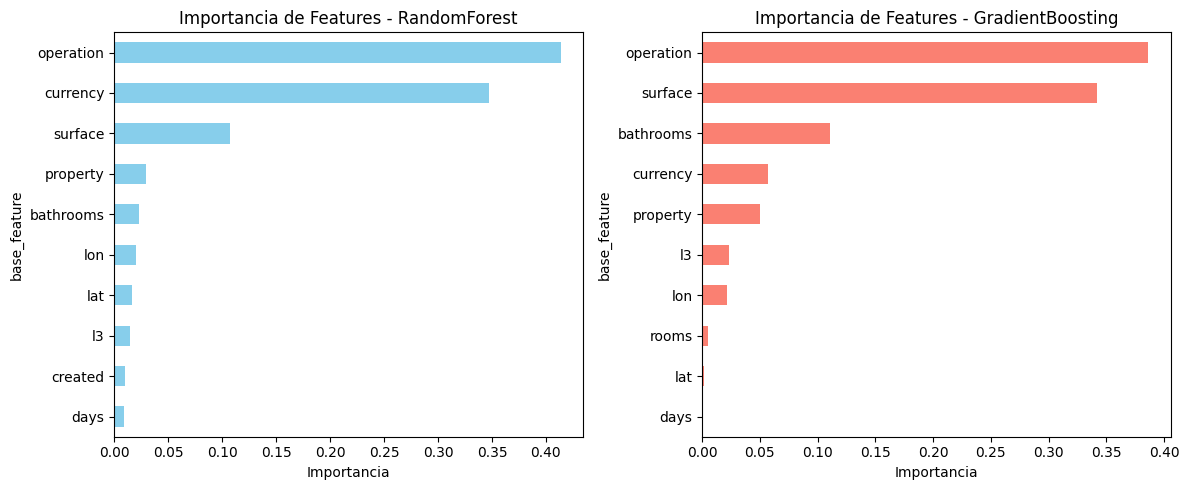

In [20]:
# Recupera nombres de features por separado
feature_names_rf = model_rf.named_steps["preproc"].get_feature_names_out()
feature_names_gb = model_gb.named_steps["preprocessor"].get_feature_names_out()

# Extraer los estimadores internos
rf_estimator = model_rf.named_steps["est"].regressor_
gb_estimator = model_gb.named_steps["model"]

# df con importance
rf_importances = pd.DataFrame({
    "feature": feature_names_rf,
    "importance": rf_estimator.feature_importances_
}).sort_values("importance", ascending=False)

gb_importances = pd.DataFrame({
    "feature": feature_names_gb,
    "importance": gb_estimator.feature_importances_
}).sort_values("importance", ascending=False)

# Agrupar por feature base
rf_importances["base_feature"] = (
    rf_importances["feature"].str.replace(r"^(num__|cat__)", "", regex=True)
    .str.split("_").str[0]
)
gb_importances["base_feature"] = (
    gb_importances["feature"].str.replace(r"^(num__|cat__)", "", regex=True)
    .str.split("_").str[0]
)

rf_grouped = rf_importances.groupby("base_feature")["importance"].sum().sort_values(ascending=False)
gb_grouped = gb_importances.groupby("base_feature")["importance"].sum().sort_values(ascending=False)

print("\n Importancia de features en modelo A (RandomForest):")
print(rf_grouped.head(10))

print("\n Importancia de features en modelo B (GradientBoosting):")
print(gb_grouped.head(10))

# --- Gráficos ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

rf_grouped.head(10).plot(kind="barh", ax=axes[0], color="skyblue")
axes[0].invert_yaxis()
axes[0].set_title("Importancia de Features - RandomForest")
axes[0].set_xlabel("Importancia")

gb_grouped.head(10).plot(kind="barh", ax=axes[1], color="salmon")
axes[1].invert_yaxis()
axes[1].set_title("Importancia de Features - GradientBoosting")
axes[1].set_xlabel("Importancia")

plt.tight_layout()
plt.show()

 operation_type y currency son categórias binarias.
En modelos de árboles se particionan fácil, tienen bajo riesgo de overfitting, y ofrecen ganancias de información grandes en los primeros splits, (importancia alta). Una vez que el árbol separó “Venta” vs “Alquiler”, recién dentro de cada rama usa surface, bathrooms, etc. para ajustar el precio fino.
Eso reduce su importancia global, aunque sean relevantes dentro de cada segmento.

In [21]:
# --- metricas ---
def evaluate(model, X_te, y_te, name="model"):
    y_pred = model.predict(X_te)
    rmse = mean_squared_error(y_te, y_pred) ** 0.5

    mae = mean_absolute_error(y_te, y_pred)
    r2 = r2_score(y_te, y_pred)
    print(f"--- {name} ---")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2: {r2:.4f}")
    return {"rmse": float(rmse), "mae": float(mae), "r2": float(r2)}


metrics_rf = evaluate(model_rf, X_test, y_test, name="RandomForest")
metrics_gb = evaluate(model_gb, X_test, y_test, name="GradientBoosting")

# --- guardar con joblib y escribe en manifest.json reemplazar con MLflow si hay tiempo ---
out_dir = "app/data/artifacts/housing_models"
os.makedirs(out_dir, exist_ok=True)
rf_path = os.path.join(out_dir, "random_forest.joblib")
gb_path = os.path.join(out_dir, "gradient_boosting.joblib")
manifest_path = os.path.join(out_dir, "manifest.json")

joblib.dump(model_rf, rf_path)
joblib.dump(model_gb, gb_path)

manifest = {
    "models": [
        {"name": "RandomForest", "path": rf_path, "metrics": metrics_rf},
        {"name": "GradientBoosting", "path": gb_path, "metrics": metrics_gb},
    ],
    "note": "Modelo guardado con joblib; se uso log1p transform",  # no aplicar np.expm1() al predecir
}

with open(manifest_path, "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2)

print("\nArchivos guardados:")
print(" -", rf_path)
print(" -", gb_path)
print(" -", manifest_path)

#  diccionario con rutas de archivos guardadas
{"random_forest": rf_path, "gradient_boosting": gb_path, "manifest": manifest_path}

--- RandomForest ---
RMSE: 49205.83
MAE: 21751.24
R2: 0.8962
--- GradientBoosting ---
RMSE: 69314.11
MAE: 43725.94
R2: 0.7940

Archivos guardados:
 - app/data/artifacts/housing_models\random_forest.joblib
 - app/data/artifacts/housing_models\gradient_boosting.joblib
 - app/data/artifacts/housing_models\manifest.json


{'random_forest': 'app/data/artifacts/housing_models\\random_forest.joblib',
 'gradient_boosting': 'app/data/artifacts/housing_models\\gradient_boosting.joblib',
 'manifest': 'app/data/artifacts/housing_models\\manifest.json'}